In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('data/ml-25m/ratings.csv')

In [83]:
MAX_SAMPLES = 128

def prep_df(df, seed=128):
    user_df = df.groupby('userId').count().sort_values(
        'rating', ascending=False)
    user_sample_df = user_df.head(MAX_SAMPLES).reset_index()['userId']
    df_sample = pd.merge(df, user_sample_df, how='inner', on='userId')

    item_df = df.groupby('movieId').count().sort_values(
        'rating', ascending=False)
    item_sample_df = item_df.head(MAX_SAMPLES).reset_index()['movieId']
    df_sample = pd.merge(df_sample, item_sample_df, how='inner', on='movieId')

    del df_sample['timestamp']
    return df_sample


def split_by_inst(df, p=0.5, seed=128):
    rng = np.random.default_rng(seed)
    state = rng.choice([0, 1], size=df.shape[0], p=[1.-p, p])
    df['split'] = state

    df = df[df['split']==1].reset_index(drop=True)
    del df['split']
    return df


def split_by_group(df, p=0.5, seed=128):
    df = df.copy()
    rng = np.random.default_rng(seed)

    user_df = df.groupby('userId').count().reset_index()
    state = rng.choice([0, 1], size=user_df.shape[0], p=[1.-p, p])
    user_df['user_state'] = state
    del user_df['movieId'], user_df['rating']

    item_df = df.groupby('movieId').count().reset_index()
    state = rng.choice([0, 1], size=item_df.shape[0], p=[1.-p, p])
    item_df['movie_state'] = state
    del item_df['userId'], item_df['rating']

    df = pd.merge(df, user_df, how='left', on='userId')
    df = pd.merge(df, item_df, how='left', on='movieId')

    df['state'] = df.apply(
        lambda x: 1 if x['user_state'] == 1 and x['movie_state'] == 1 else
            -1 if x['user_state'] == 0 and x['movie_state'] == 0 else 0,
        axis=1)
    del df['user_state'], df['movie_state']

    train_df = df[df['state'] == 1].reset_index(drop=True)
    test_df = df[df['state'] == -1].reset_index(drop=True)
    del train_df['state']
    del test_df['state']

    return train_df, test_df


def missing(df, p=0.5, seed=128):
    rng = np.random.default_rng(seed)
    state = rng.choice([False, True], size=df.shape[0], p=[p, 1-p])
    df['missing'] = state
    return df


train_df, test_df = split_by_group(split_by_inst(prep_df(df), p=0.5), p=0.5)
test_df = missing(test_df)
print(train_df)
print(test_df)


      userId  movieId  rating
0        548        1     4.5
1      12857        1     3.0
2      17474        1     4.0
3      17783        1     4.0
4      18306        1     5.0
...      ...      ...     ...
1885  144475    60069     5.0
1886  146221    60069     4.5
1887  156183    60069     4.5
1888  160747    60069     3.0
1889  162047    60069     3.5

[1890 rows x 3 columns]
      userId  movieId  rating  missing
0       1748       10     4.5     True
1       8619       10     3.0    False
2      12244       10     3.5    False
3      20179       10     3.0    False
4      22253       10     4.0    False
...      ...      ...     ...      ...
1810  141938     1206     3.5    False
1811  143049     1206     4.0     True
1812  145873     1206     5.0     True
1813  152107     1206     4.5     True
1814  162271     1206     4.5     True

[1815 rows x 4 columns]


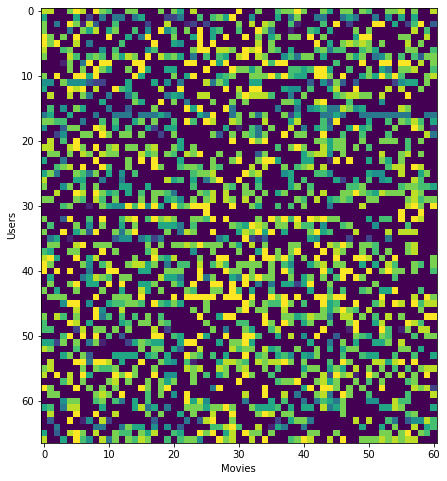

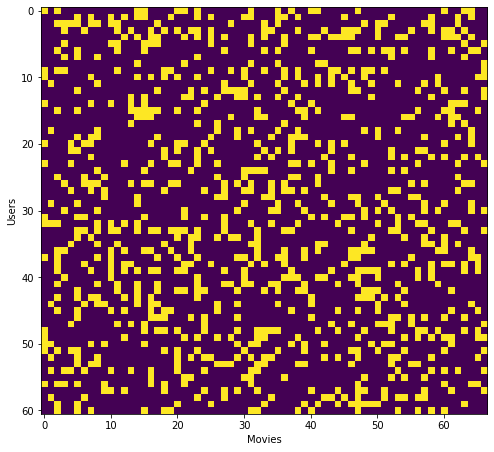

In [84]:
def plot_ratings(df, col):
    df = df.copy()
    df['user_idx'] = df['userId'].rank(method='dense').astype(int) - 1
    df['movie_idx'] = df['movieId'].rank(method='dense').astype(int) - 1

    num_users = df['user_idx'].max() + 1
    num_movies = df['movie_idx'].max() + 1
    rating_mat = np.zeros((num_users, num_movies))

    for idx in range(df.shape[0]):
        rating_mat[df['user_idx'][idx],
            df['movie_idx'][idx]] = df[col][idx]

    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(rating_mat)
    ax.set_xlabel("Movies")
    ax.set_ylabel("Users")
    plt.show()

plot_ratings(train_df, 'rating')
plot_ratings(test_df, 'missing')


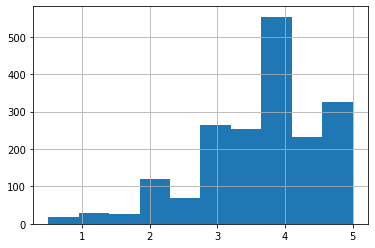

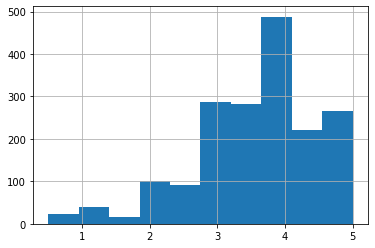

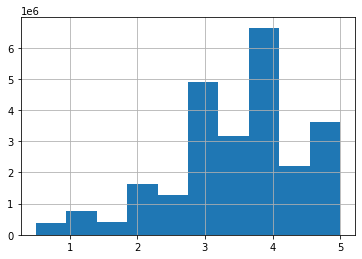

In [85]:
train_df['rating'].hist()
plt.show()
test_df['rating'].hist()
plt.show()
df['rating'].hist()
plt.show()


In [86]:
from src.model import Model
import sys
import math

In [97]:
NUM_EPOCHS = 64

model = Model()

train_user_df = train_df.groupby('userId').count().reset_index()['userId']
test_user_df = test_df.groupby('userId').count().reset_index()['userId']

train_errs = np.zeros(NUM_EPOCHS)
rec_errs = np.zeros(NUM_EPOCHS)
trans_errs = np.zeros(NUM_EPOCHS)
for epoch_idx in range(NUM_EPOCHS):
    train_error = 0
    for user_id in train_user_df:
        x = train_df[train_df['userId']==user_id]['rating'].to_numpy().reshape(-1, 1)
        model.step(x)
        x_rec = model.reconstruct(x)
        train_error += np.sum((x - x_rec)**2)
    train_error /= train_df.shape[0]
    train_errs[epoch_idx] = train_error

    result_df = test_df.copy()
    result_df['u'] = result_df.apply(lambda x: None, axis=1)
    result_df['v'] = result_df.apply(lambda x: None, axis=1)

    for user_id in test_user_df:
        batch_df = test_df[(test_df['userId'] == user_id)
            & (test_df['missing'] == False)].copy()
        x = batch_df['rating'].to_numpy().reshape(-1, 1)
        del batch_df['rating'], batch_df['missing']
        u, v = model.get_latents(x)
        batch_df['u_new'] = batch_df.apply(lambda x: u[0], axis=1)
        batch_df['v_new'] = [r for r in v]

        result_df = result_df.merge(
            batch_df, how='left', on=['userId', 'movieId'])
        result_df['u'] = result_df.apply(
            lambda x: x['u_new'] if type(x['u_new']) is np.ndarray
            else x['u'], axis=1)
        result_df['v'] = result_df.apply(
            lambda x: x['v_new'] if type(x['v_new']) is np.ndarray
            else x['v'], axis=1)

        del result_df['u_new'], result_df['v_new']

    u_df = result_df.groupby('userId')['u'].apply(lambda x: np.mean(x))
    v_df = result_df.groupby('movieId')['v'].apply(lambda x: np.mean(x))

    del result_df['u'], result_df['v']

    result_df = pd.merge(result_df, u_df, how='left', on='userId')
    result_df = pd.merge(result_df, v_df, how='left', on='movieId')

    u = np.array(list(result_df['u']))
    v = np.array(list(result_df['v']))
    result_df['pred'] = model.decode(u, v)[:, 0]
    
    del result_df['u'], result_df['v']

    result_df['mse'] = result_df.apply(
        lambda x: (x['pred'] - x['rating'])**2, axis=1)
    trans_error = np.mean(result_df[result_df['missing'] == True]['mse'])
    rec_error = np.mean(result_df[result_df['missing'] == False]['mse'])

    trans_errs[epoch_idx] = trans_error
    rec_errs[epoch_idx] = rec_error

    print("[epoch %d] train_error: %.2f, rec_error: %.2f, trans_error: %.2f" 
        % (epoch_idx, train_error, rec_error, trans_error))
    # print(result_df[['rating', 'pred', 'mse']])


[epoch 0] train_error: 3.11, rec_error: 1.64, trans_error: 1.60
[epoch 1] train_error: 2.01, rec_error: 1.24, trans_error: 1.22
[epoch 2] train_error: 1.50, rec_error: 0.98, trans_error: 1.00
[epoch 3] train_error: 1.11, rec_error: 1.02, trans_error: 1.04
[epoch 4] train_error: 0.80, rec_error: 1.01, trans_error: 1.05
[epoch 5] train_error: 0.57, rec_error: 0.90, trans_error: 0.96
[epoch 6] train_error: 0.48, rec_error: 0.82, trans_error: 0.85
[epoch 7] train_error: 0.40, rec_error: 0.82, trans_error: 0.88
[epoch 8] train_error: 0.40, rec_error: 0.87, trans_error: 0.91
[epoch 9] train_error: 0.32, rec_error: 0.87, trans_error: 0.87
[epoch 10] train_error: 0.32, rec_error: 0.80, trans_error: 0.85
[epoch 11] train_error: 0.28, rec_error: 0.81, trans_error: 0.86
[epoch 12] train_error: 0.28, rec_error: 0.80, trans_error: 0.87
[epoch 13] train_error: 0.25, rec_error: 0.84, trans_error: 0.89
[epoch 14] train_error: 0.22, rec_error: 0.84, trans_error: 0.88
[epoch 15] train_error: 0.22, rec_e

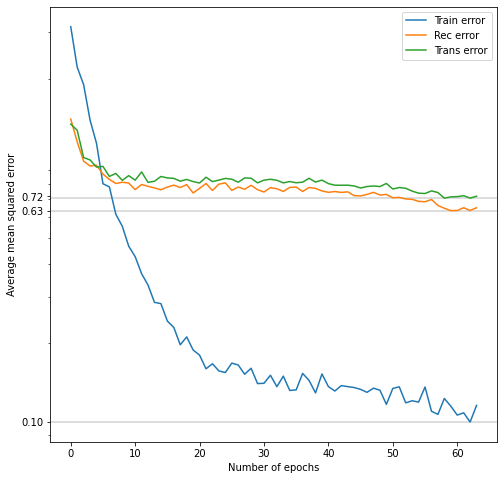

In [95]:
_ = plt.figure(figsize=(8, 8))
plt.axhline(np.min(train_errs), color='lightgray')
plt.axhline(np.min(rec_errs), color='lightgray')
plt.axhline(np.min(trans_errs), color='lightgray')
epochs = np.arange(NUM_EPOCHS)
plt.plot(epochs, train_errs, label="Train error")
plt.plot(epochs, rec_errs, label="Rec error")
plt.plot(epochs, trans_errs, label="Trans error")
plt.xlabel("Number of epochs")
plt.ylabel("Average mean squared error")
plt.legend()
plt.yscale("log")
plt.yticks([np.min(train_errs), np.min(rec_errs), np.min(trans_error)], [
           "%.2f" % (np.min(train_errs)), "%.2f" % (np.min(rec_errs)),
           "%.2f" % (np.min(trans_error))])
plt.show()


<Figure size 576x432 with 0 Axes>

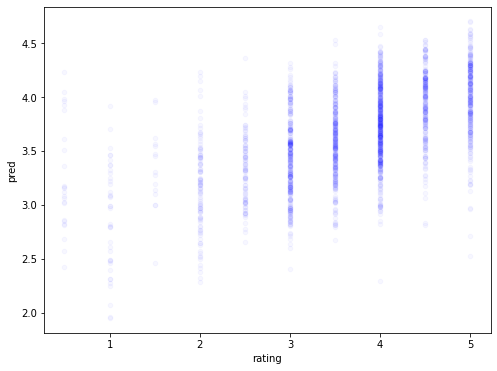

In [96]:
_ = plt.figure(figsize=(8, 6))
result_df.plot.scatter('rating', 'pred', c='blue', alpha=0.03, figsize=(8, 6))
plt.show()

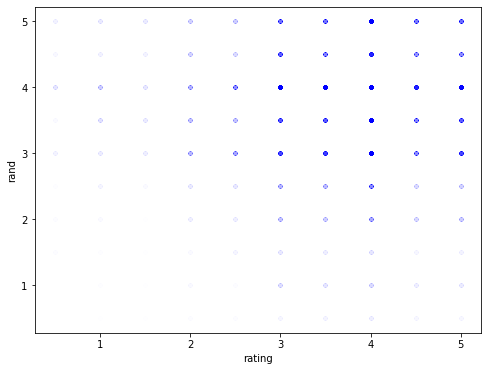

In [75]:
rand_df = test_df.copy()
rand_df['rand'] = np.random.choice(rand_df['rating'].values, rand_df.shape[0])
rand_df['mse'] = (rand_df['rand'] - rand_df['rating'])**2
rand_err = np.mean(rand_df['mse'])

rand_df.plot.scatter('rating', 'rand', c='blue', alpha=0.005, figsize=(8, 6))
plt.show()
